In [ ]:
import pandas as pd

In [ ]:
df = pd.read_excel('Online Retail.xlsx')

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Data Preprocesisng

In [ ]:
df.shape

(541909, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
df = df.dropna(subset=['CustomerID'])

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [ ]:
df = df[df['Quantity']>0]

In [ ]:
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## Feature Engineering

**RFM(Recency, Frequency, Monetary) Analysis**


---


	1.	Recency (R) → How recently a customer made a purchase.
	2.	Frequency (F) → How often they purchase.
	3.	Monetary (M) → How much they spend in total.


🔹 Why Use RFM?

✅ Helps segment customers into different groups (e.g., loyal, at-risk, new).<br>
✅ Improves marketing strategies (e.g., targeted promotions).<br>
✅ Enhances customer retention efforts.














In [ ]:
import datetime

# latest date (snapshot date)

snapshot_date = df['InvoiceDate'].max() + datetime.timedelta(days=1)



rfm = df.groupby('CustomerID').agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum'
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalAmount': 'Monetary'})



In [ ]:
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


| Segment |	Description |
|  ---     |  ---        |
|Best Customers|	High Frequency, High Monetary, Low Recency (recently active)|
|Loyal Customers	|High Frequency, Medium Monetary|
|At Risk Customers|Medium Frequency, Medium Monetary, High Recency (not active recently)|
| Lost Customers	|Low Frequency, Low Monetary, High Recency|

## Apply clustering Algorithms

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

rfm_scaled = scaler.fit_transform(rfm)

In [ ]:
from sklearn.cluster import KMeans

k = 4

kmeans = KMeans(n_clusters=k, random_state=42)

In [ ]:
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

print(rfm.head())

            Recency  Frequency  Monetary  Cluster
CustomerID                                       
12346.0         326          1  77183.60        0
12347.0           2          7   4310.00        3
12348.0          75          4   1797.24        3
12349.0          19          1   1757.55        3
12350.0         310          1    334.40        1


## Visualize the Clusters

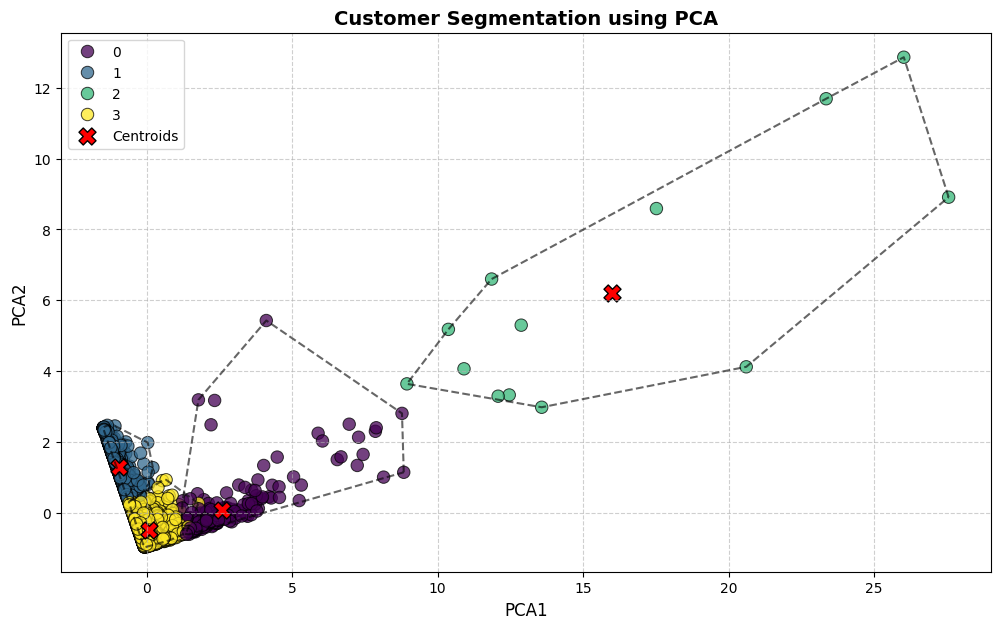

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull

# Perform PCA
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)
rfm['PCA1'] = rfm_pca[:, 0]
rfm['PCA2'] = rfm_pca[:, 1]

# Define colors and styles
palette = sns.color_palette("viridis", as_cmap=True)

# Plot
plt.figure(figsize=(12, 7))
sns.scatterplot(data=rfm, x="PCA1", y="PCA2", hue="Cluster", palette="viridis", s=80, edgecolor="black", alpha=0.75)

# Calculate centroids for each cluster
centroids = rfm.groupby("Cluster")[["PCA1", "PCA2"]].mean()

# Plot centroids
plt.scatter(centroids["PCA1"], centroids["PCA2"], c="red", s=150, marker="X", edgecolors="black", label="Centroids")

# Optional: Draw Convex Hulls around clusters
for cluster in rfm["Cluster"].unique():
    cluster_points = rfm[rfm["Cluster"] == cluster][["PCA1", "PCA2"]].values
    if len(cluster_points) > 2:  # Convex hull requires at least 3 points
        hull = ConvexHull(cluster_points)
        hull_points = np.append(hull.vertices, hull.vertices[0])  # Close the shape
        plt.plot(cluster_points[hull_points, 0], cluster_points[hull_points, 1], "--", lw=1.5, color="black", alpha=0.6)

# Labels and Title
plt.xlabel("PCA1", fontsize=12)
plt.ylabel("PCA2", fontsize=12)
plt.title("Customer Segmentation using PCA", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Show Plot
plt.show()